# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [100]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [101]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD


# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [102]:
# données
X = np.genfromtxt("data.csv", delimiter=",", dtype=int)
df = pd.read_csv("data.csv", nrows=5000)
X.shape


(5000, 400)

In [103]:
# étiquettes
Y = np.genfromtxt("labels.csv", delimiter=",", dtype=int)
Y.shape


(5000,)

Afficher aléatoirement quelques données de notre base

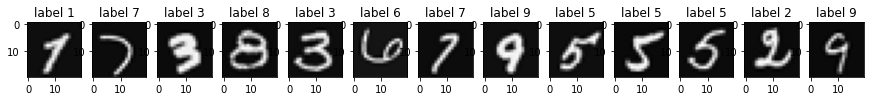

In [104]:
plt.figure(figsize=(15, 8))
for i in range(13):  # note: each 500 lines, there is a new value
    c = random.randint(X.shape[0])  # pick a random line from the dataset
    a = X[c, :].reshape((20, 20))  # shape of one number in the image
    a = np.transpose(a)  # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1, 13, i + 1)
    plt.title("label " + str(Y[c]))
    plt.imshow(a, cmap="gray")


Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion


In [105]:
def confusion_matrix(actual_values, predicted_values):
    cm = np.zeros((10, 10))
    for i in range(len(actual_values)):
        cm[actual_values[i] - 1][predicted_values[i] - 1] += 1

    return cm.astype(np.int64)


def get_parameters(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = np.sum(confusion_matrix) - (FP + FN + TP)
    return (FP, FN, TP, TN)


- Rappel :

In [106]:
def recall(confusion_matrix):
    FP, FN, TP, TN = get_parameters(confusion_matrix)
    return np.nan_to_num(TP / (TP + FN))


- Précision

In [107]:
def precision(confusion_matrix):
    FP, FN, TP, TN = get_parameters(confusion_matrix)
    return np.nan_to_num(TP / (TP + FP))


- Taux de FP

In [108]:
def fallout(confusion_matrix):
    FP, FN, TP, TN = get_parameters(confusion_matrix)
    return np.nan_to_num(FP / (FP + TN))


- Spécificité

In [109]:
def specifity(confusion_matrix):
    FP, FN, TP, TN = get_parameters(confusion_matrix)
    return np.nan_to_num(TN / (TN + FP))


- Courbe ROC

<ipython-input-106-1c82d00c4560>:3: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(TP / (TP + FN))


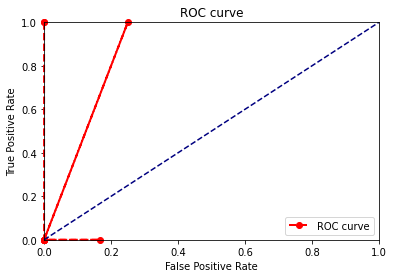

In [110]:
def roc(confusion_matrix):
    fpr = fallout(confusion_matrix)
    tpr = recall(confusion_matrix)
    plt.plot(
        fpr,
        tpr,
        linestyle="--",
        marker="o",
        color="red",
        lw=2,
        label="ROC curve",
        clip_on=False,
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


conf_mat = confusion_matrix([1, 2, 3, 8, 8, 4], [1, 2, 8, 8, 8, 6])
# fallout(conf_mat)
roc(conf_mat)


# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [111]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(scaled_features, Y, test_size=0.30)


# Méthode 0: K- Plus Proches Voisins

Fonction pour calculer la distance euclidienne entre deux vecteurs.

In [112]:
def euclidean(v1, v2):
    if len(v1) != len(v2):
        raise Exception("Incompatible dimensions")
    distance = 0.0
    for i in range(len(v1) - 1):
        distance += (v1[i] - v2[i]) ** 2

    return np.sqrt(distance)


Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

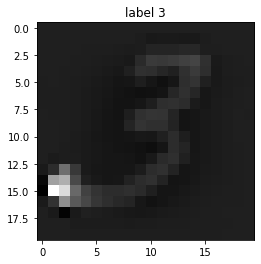

In [113]:
def KPP(x_train, y_train, x, k):
    distances = []
    for i in range(len(x_train)):
        distances.append((y_train[i], euclidean(x, x_train[i])))

    K_neighbors = [
        label for label, distance in sorted(distances, key=lambda x: x[1])[:k]
    ]
    nearest_neighbor = max(set(K_neighbors), key=K_neighbors.count)
    return nearest_neighbor


# tester une image
c = random.randint(Xtt.shape[0])
y_pred = KPP(Xt, Yt, Xtt[c], 5)
a = Xtt[c, :].reshape((20, 20))
a = np.transpose(a)
plt.title("label " + str(y_pred))
plt.imshow(a, cmap="gray")


# Méthode 1: MVS
Machine à Vecteurs de Support

In [114]:
# Créer le modèle
model = svm.SVC(kernel="linear")
# entrainement
model.fit(Xt, Yt)
# Prediction
y_pred_mvs = model.predict(Xtt)


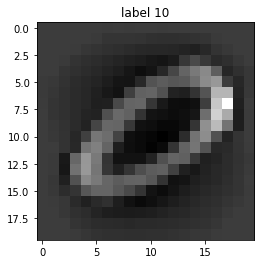

In [115]:
# tester une image
c = random.randint(Xtt.shape[0])
a = Xtt[c, :].reshape((20, 20))
a = np.transpose(a)
plt.title("label " + str(y_pred_mvs[c]))
plt.imshow(a, cmap="gray")


# Méthode 2: Arbres de décision


In [116]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred_tree = model.predict(Xtt)


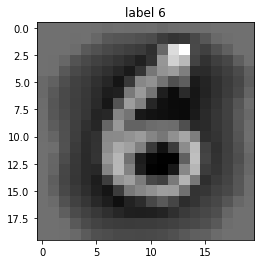

In [117]:
# tester une image
c = random.randint(Xtt.shape[0])
a = Xtt[c, :].reshape((20, 20))
a = np.transpose(a)
plt.title("label " + str(y_pred_tree[c]))
plt.imshow(a, cmap="gray")


# Méthode 3: RN 
Réseaux de neurones Perceptron

In [118]:
model = MLPClassifier(
    solver="sgd", alpha=1e-5, hidden_layer_sizes=(25), max_iter=100000
)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [119]:
y_pred_rn = model.predict(Xtt)


In [120]:
# pour ROC, il faudra les probabilités:
y_pred_rnproba = model.predict_proba(Xtt)


Afficher l'image testée

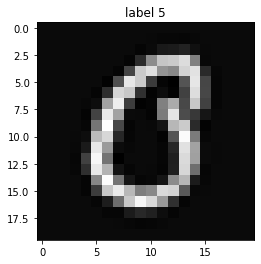

In [121]:
c = random.randint(Xtt.shape[0])
a = Xtt[c, :].reshape((20, 20))
a = np.transpose(a)
plt.title("label " + str(y_pred_rn[c]))
plt.imshow(a, cmap="gray")


# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [122]:
# reshape dataset to have a single channel

Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))


In [123]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)[:,:-1]
Ytt_rnc = to_categorical(Ytt)[:,:-1]

Xt_rncN = Xt_rnc.astype("float32")
Xtt_rncN = Xtt_rnc.astype("float32")

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform", input_shape=(20, 20, 1),))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(10, activation="softmax"))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)
y_pred_rnc = model.predict(Xtt_rncN)
y_pred_rnc.shape


(3500, 10)

# Appliquer les métriques implementées pour voir le résultat

## Méthode 0 : KPP

In [124]:
ypred = []
Xt, Xtt, Yt, Ytt = train_test_split(scaled_features, Y, test_size=0.30)
for i in range(len(Xtt)):
    ypred.append(KPP(Xt, Yt, Xtt[i], 5))


rappel KPP        = [0.98742138 0.85806452 0.84722222 0.81012658 0.74015748 0.91566265
 0.86956522 0.82733813 0.87820513 0.96202532]
precision KPP   = [0.86263736 0.9047619  0.83561644 0.8951049  0.87850467 0.95597484
 0.87591241 0.8041958  0.80588235 0.91566265]
Taux FP KPP     = [0.0186428  0.01040892 0.01769912 0.01117735 0.00946832 0.00524738
 0.01248164 0.02057311 0.02455357 0.01043219]
Specificite KPP = [0.9813572  0.98959108 0.98230088 0.98882265 0.99053168 0.99475262
 0.98751836 0.97942689 0.97544643 0.98956781]


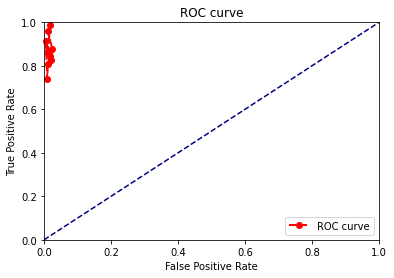

In [130]:
m0 = confusion_matrix(Ytt, ypred)
print(f"rappel KPP        = {recall(m0)}")
print(f"precision KPP   = {precision(m0)}")
print(f"Taux FP KPP     = {fallout(m0)}")
print(f"Specificite KPP = {specifity(m0)}")
roc(m0)


## Méthode 1 : MVS

rappel MVS        = [0.05660377 0.13548387 0.11805556 0.05696203 0.07874016 0.11445783
 0.07246377 0.05035971 0.12179487 0.07594937]
precision MVS   = [0.05660377 0.12650602 0.12142857 0.0625     0.06493506 0.12179487
 0.06369427 0.05511811 0.13194444 0.07843137]
Taux FP MVS     = [0.11185682 0.10780669 0.09070796 0.10059613 0.10487983 0.10269865
 0.10792952 0.08817046 0.09300595 0.10506706]
Specificite MVS = [0.88814318 0.89219331 0.90929204 0.89940387 0.89512017 0.89730135
 0.89207048 0.91182954 0.90699405 0.89493294]


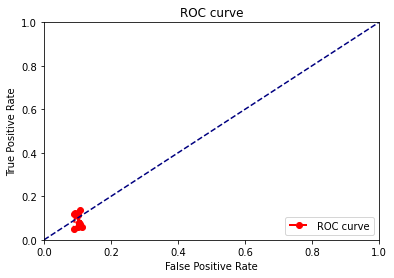

In [126]:
m1 = confusion_matrix(Ytt, y_pred_mvs)
print(f"rappel MVS        = {recall(m1)}")
print(f"precision MVS   = {precision(m1)}")
print(f"Taux FP MVS     = {fallout(m1)}")
print(f"Specificite MVS = {specifity(m1)}")
roc(m1)


## Méthode 2 : DT

rappel DT        = [0.06289308 0.09032258 0.14583333 0.07594937 0.09448819 0.10843373
 0.07971014 0.08633094 0.09615385 0.06962025]
precision DT   = [0.06896552 0.09589041 0.13636364 0.08391608 0.08571429 0.11612903
 0.06547619 0.08759124 0.1048951  0.06508876]
Taux FP DT     = [0.10067114 0.09814126 0.0980826  0.0976155  0.09322651 0.10269865
 0.11527166 0.09184423 0.0952381  0.11773472]
Specificite DT = [0.89932886 0.90185874 0.9019174  0.9023845  0.90677349 0.89730135
 0.88472834 0.90815577 0.9047619  0.88226528]


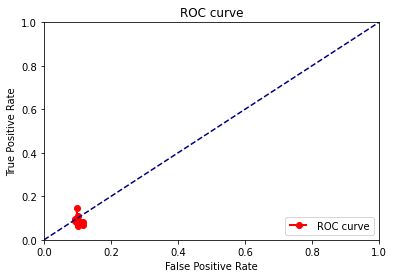

In [127]:
m2 = confusion_matrix(Ytt, y_pred_tree)
print(f"rappel DT        = {recall(m2)}")
print(f"precision DT   = {precision(m2)}")
print(f"Taux FP DT     = {fallout(m2)}")
print(f"Specificite DT = {specifity(m2)}")
roc(m2)


## Méthode 3: RN

rappel RN        = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
precision RN   = [0.         0.         0.         0.         0.08466667 0.
 0.         0.         0.         0.        ]
Taux FP RN     = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Specificite RN = [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]


<ipython-input-107-60a5a4f87e67>:3: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(TP / (TP + FP))


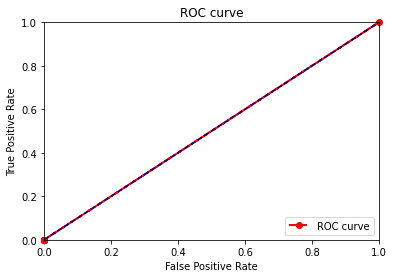

In [128]:
m3 = confusion_matrix(Ytt, y_pred_rn)
print(f"rappel RN        = {recall(m3)}")
print(f"precision RN   = {precision(m3)}")
print(f"Taux FP RN     = {fallout(m3)}")
print(f"Specificite RN = {specifity(m3)}")
roc(m3)


# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

In [129]:
# bonne chance
